# Predicting Olympic Medal Success through Past Participation


## Import Dependencies and Dataset

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc 


import matplotlib.pyplot as plt
import seaborn as sns

import pprint as pp

df = pd.read_csv("athlete_events.csv")


# Display athletes who's participated multiple times.
value_counts = df['ID'].value_counts()
filtered_df = df[df['ID'].isin(value_counts[value_counts > 1].index)]
filtered_df.head(6)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,NaN
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",NaN


## Preprocessing

### Transformation
Represent an Athlete's Olympic Experience based on previous games played by creating 3 new columns:

**Event_exp** - Number of previous participations for a specific event. (Speed Skating Women's 500 metres)

**Sport_exp** - Number of previous participations for a specific sport. (Speed Skating)

**Total_exp** - Total number of previous participations.

These won't be fed into the regression simultaneously to avoid multicollinearity. They will be interchanged however to explore effects on model performance.

In [2]:
df = df.sort_values(by='Year', ascending=True)

df['Event_exp'] = df.groupby(['ID', "Event"]).cumcount()
df['Sport_exp'] = df.groupby(['ID', "Sport"]).cumcount()
df['Total_exp'] = df.groupby('ID').cumcount()

value_counts = df['ID'].value_counts()
filtered_df = df[df['ID'].isin(value_counts[value_counts > 1].index)]
filtered_df.head(6)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Event_exp,Sport_exp,Total_exp
214333,107607,Fritz Richard Gustav Schuft,M,19.0,NaN,NaN,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Pommelled Horse,NaN,0,0,0
244717,122526,Pierre Alexandre Tuffri,M,19.0,NaN,NaN,France,FRA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's Triple Jump,Silver,0,0,0
244716,122526,Pierre Alexandre Tuffri,M,19.0,NaN,NaN,France,FRA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's Long Jump,NaN,0,1,1
23912,12563,Conrad Helmut Fritz Bcker,M,25.0,NaN,NaN,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Horse Vault,NaN,0,0,0
23913,12563,Conrad Helmut Fritz Bcker,M,25.0,NaN,NaN,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Parallel Bars,NaN,0,1,1
23914,12563,Conrad Helmut Fritz Bcker,M,25.0,NaN,NaN,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold,0,2,2


### Encoding Medal Success

With Logistic Regression, all inputs must be numerical values. Thus, categorical values are encoded into numerical representation.

Let's start with a binary classification. Simplify the 4 levels of column Medal to a binary input of No Medal or Medalist.

In [3]:
#df['Medal'] = df['Medal'].apply(lambda x: 0 if pd.isna(x) else 1)

df['Medal'] = df['Medal'].replace({
    None: 0,
    'Bronze': 1,
    'Silver': 2,
    'Gold': 3
}).astype(int)

df['Medalist'] = df['Medal'].apply(lambda x: 0 if x < 1 else 1)


## Cleaning

Post exploration, we noticed that athletes in the Art Competition sport are outliers in the event exp. These are the only olympians reaching past 8 Event_exp and had a max of 47. Let's exclude this sport and focus on the physical events.


Drop the irrelevant features and opt to exclude athletes that have null attributes in the remaining.

In [4]:
df[df["Event_exp"]>8]["Sport"].unique()


array(['Art Competitions'], dtype=object)

In [5]:
df[df["Event_exp"]>8]["Event_exp"].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47])

In [6]:
backup_df = df

df = df[df["Sport"] != "Art Competitions"]
df = df.drop(columns=["ID", "Height", "Weight", "Name", "Team", "NOC", "Games", "Year", "Sport", "Season", "City", "Event"], axis=1)
df = df.dropna()

## Model Training

In the first iteration of model training, only a single independent variable is used for simplicity. What is the effect of compounding experience in specific events on the athlete's medal success at said event?

In [7]:
logisticRegr = LogisticRegression()

feature_cols = ['Event_exp']
x = df[feature_cols]
y = df.Medalist

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.3, random_state=69)

logisticRegr.fit(x_train, y_train)
binary_predictions = logisticRegr.predict(x_test)
proba_predictions = logisticRegr.predict_proba(x_test)[:, 1]


## Evaluation

In [8]:
score = logisticRegr.score(x_test, y_test)
print(f"Accuracy = {score}")

Accuracy = 0.8503454854844531


### Accuracy Paradox

The model scores a high 85.43% accuracy. This however is bad metric for evaluating performance. With an imbalanced dataset (more non-medalists than medalists), the model is biased to predict the majority class. This explains the
- 100% minority class prediction recall
- Only false negatives
- No false positives.

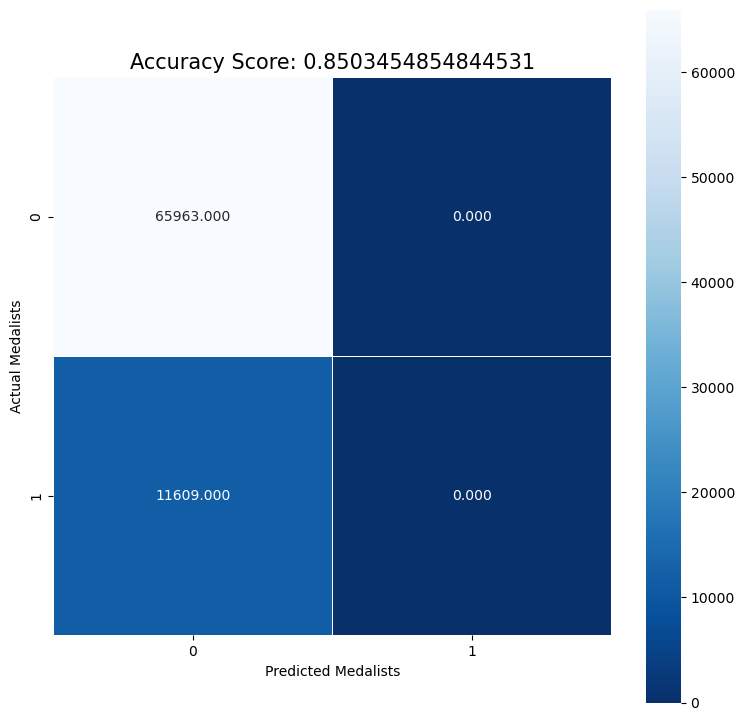

In [9]:
cm = metrics.confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Medalists');
plt.xlabel('Predicted Medalists');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Weighted Classes

The coefficients of the minority class are now proportionally higher and improves the model's bias. Now, the model is at least identifying true positives. The significant drop in accuracy is easily neglected with our focus on the positive class.

In [10]:
logisticRegr = LogisticRegression(class_weight='balanced')

logisticRegr.fit(x_train, y_train)
binary_predictions = logisticRegr.predict(x_test)
proba_predictions = logisticRegr.predict_proba(x_test)[:, 1]


score = logisticRegr.score(x_test, y_test)

n_splits = 10
cv = KFold(n_splits=n_splits)
scores = cross_val_score(
    logisticRegr, x, y, scoring='accuracy', cv=cv, n_jobs=-1)


print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))


Accuracy: 0.699 ,
Standard Deviations :0.039


### Confusion Matrix

- **Top left** - True negatives
- **Top right** - False positives
- **Bottom left** - False negatives
- **Bottom right** - True positives



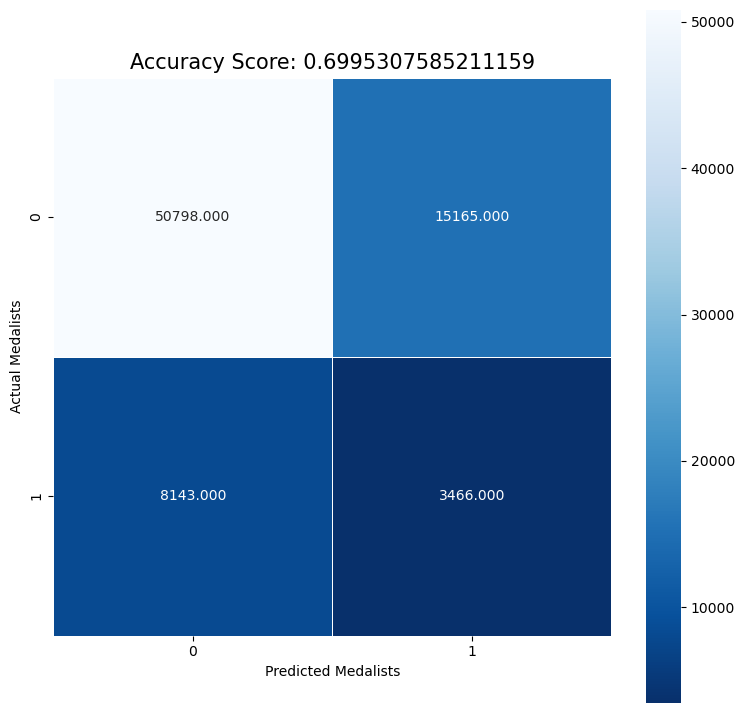

In [11]:
cm = metrics.confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Medalists');
plt.xlabel('Predicted Medalists');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Precision, Recall, F1 Score

To better understand the implications of the confusion matrix, use other model perfomance metrics. Since positives are the valuable insight in these predictions, precision, recall, and F1 score all quantify insights on the pertinant focus. The results indicate

- Precision - Most predicted medalists are false (82.4%)
- Recall - Only ⅓ of true medalists were predicted.
- F1 Score - Overall, low predictive performance.

In [12]:
precision = metrics.precision_score(y_test, binary_predictions)
recall = metrics.recall_score(y_test,binary_predictions)
f1score = metrics.f1_score(y_test, binary_predictions)

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.18603402930599539
Recall = 0.2985614609354811
F1 Score = 0.2292328042328042


## Probabilistic Classification

So far, binary classification has been the focus of model evaluation and data visualization. Logistic regression however is a probabilistic model. These probabilities were just binned into either classes on an arbitrary 50% decision threshold (a y with 51% probability is classified into the most probable class).

Moving on, this is a visualization of medal success probabilities with compounding experience in specified events. It is to be concluded that event experience is positively correlated with medal success.

<AxesSubplot: xlabel='Event_exp', ylabel='Medalist'>

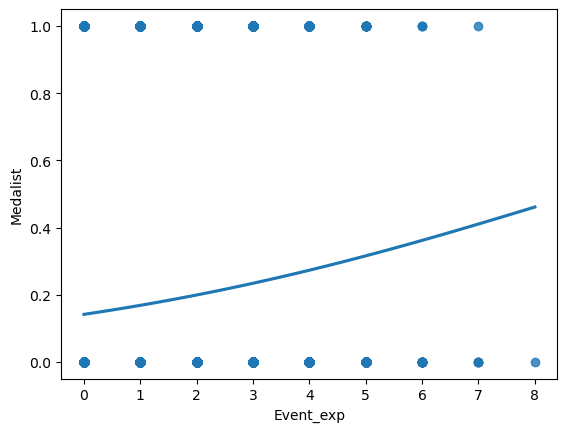

In [13]:
sns.regplot(x=x, y=y, data=df, logistic=True, ci=None)

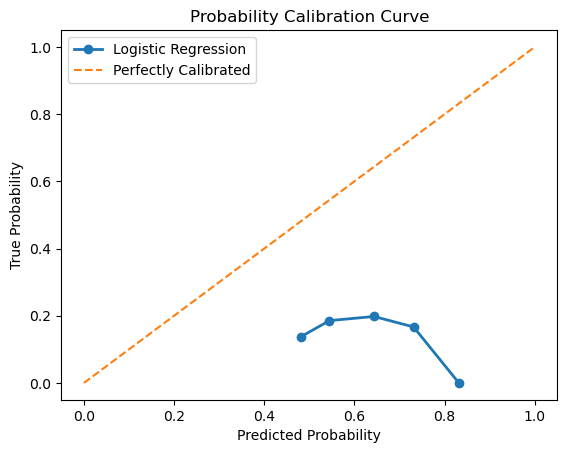

In [14]:
true_pos, pred_pos = calibration_curve(y_test, proba_predictions, n_bins=10)

plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=2, 
         label='Logistic Regression')

#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
 
 
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
 
# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

Area Under the ROC Curve for threshold 0.5: 0.5354787159378603
Area Under the ROC Curve for threshold 0.9: 0.5


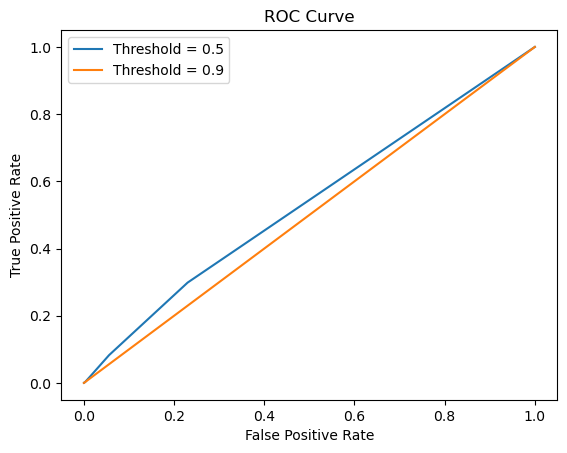

In [15]:
threshold = 0.9

y_pred_new_threshold = (logisticRegr.predict_proba(x_test)[:, 1] >= threshold).astype(int) 


# ROC Curve 
y_scores = logisticRegr.predict_proba(x_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_scores) 
plt.plot(fpr, tpr,  label = f'Threshold = 0.5') 
print('Area Under the ROC Curve for threshold 0.5:', roc_auc_score(y_test, y_scores)) 
  
# For Threshold 0.9 
fpr_, tpr_, thresholds_ = roc_curve(y_test, y_pred_new_threshold) 
print(f'Area Under the ROC Curve for threshold {threshold}:', roc_auc_score(y_test, y_pred_new_threshold)) 
plt.plot(fpr_, tpr_, label = f'Threshold = {threshold}') 
  
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend() 
plt.show()

Area Under the Curve (AUC) for threshold 0.5: 0.1762983623830044
Area Under the Curve (AUC) for threshold 0.9: 0.5748272572577734


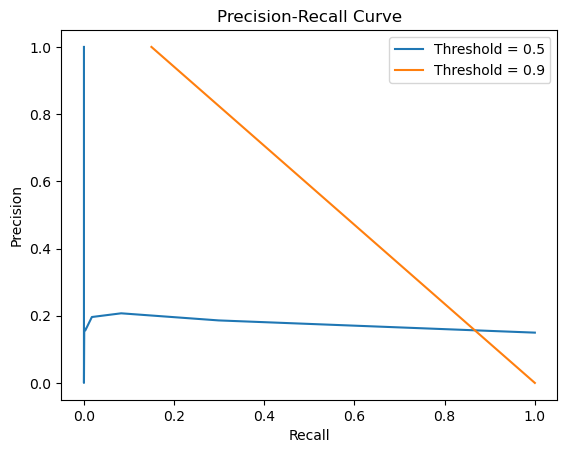

In [16]:

# Precision Recall curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_scores) 
plt.plot(recall, precision, label = 'Threshold = 0.5') 
print('Area Under the Curve (AUC) for threshold 0.5:', auc(recall, precision)) 
# For Threshold 0.9 
precision_, recall_, thresholds_ = precision_recall_curve(y_test, y_pred_new_threshold) 
plt.plot(precision_, recall_, label = 'Threshold = 0.9') 
print('Area Under the Curve (AUC) for threshold 0.9:', auc(recall_, precision_)) 
  
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.title('Precision-Recall Curve') 
plt.legend() 
plt.show()

## Total experience as Predictor

Exploring Total_exp, it's found that it has the virtually the same outputs as Sport_exp (not shown), and performs slightly better overall with deteroriation in precision accompanied by significant recall improvement.

In [17]:
logisticRegr = LogisticRegression(class_weight='balanced')

feature_cols = ['Total_exp']
x = df[feature_cols]

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.3, random_state=69)

logisticRegr.fit(x_train, y_train)
binary_predictions = logisticRegr.predict(x_test)
proba_predictions = logisticRegr.predict_proba(x_test)[:, 1]

score = logisticRegr.score(x_test, y_test)
print(f"Accuracy = {score}")

precision = metrics.precision_score(y_test, binary_predictions)
recall = metrics.recall_score(y_test,binary_predictions)
f1score = metrics.f1_score(y_test, binary_predictions)

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Accuracy = 0.35944670757489816
Precision = 0.15341488277268095
Recall = 0.7259884572314583
F1 Score = 0.2533022766548952


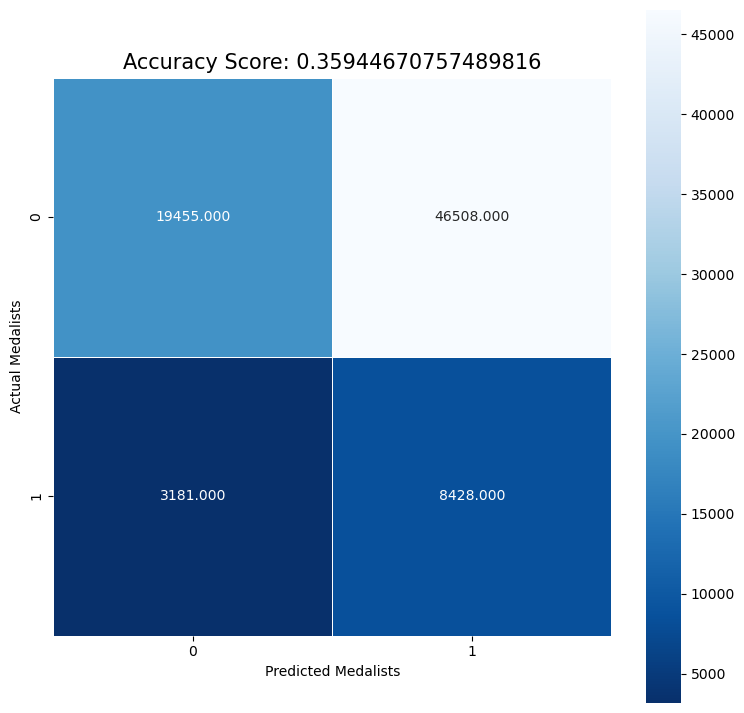

In [18]:
cm = metrics.confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Medalists');
plt.xlabel('Predicted Medalists');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

<AxesSubplot: xlabel='Total_exp', ylabel='Medalist'>

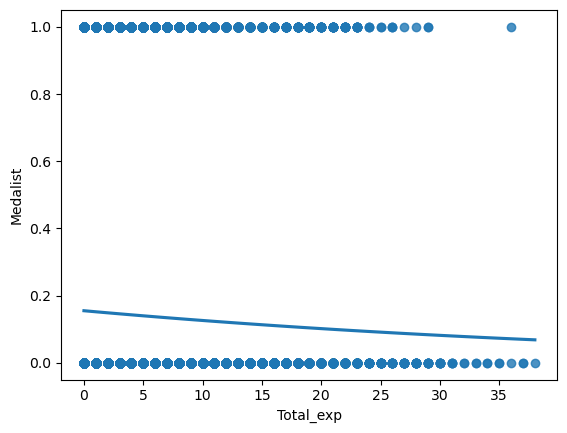

In [19]:
sns.regplot(x=x, y=y, data=df, logistic=True, ci=None)

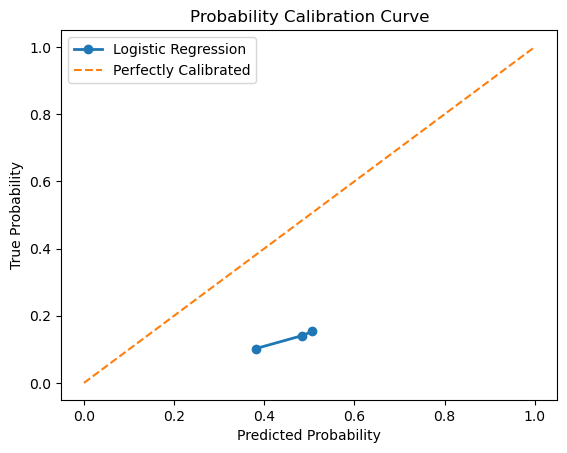

In [20]:
true_pos, pred_pos = calibration_curve(y_test, proba_predictions, n_bins=10)

plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=2, 
         label='Logistic Regression')

#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
 
 
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
 
# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

## Multiclassification and Higher Feature Dimension

In [21]:
df = backup_df

df = df[df["Sport"] != "Art Competitions"]
df = df.drop(columns=["ID", "Name", "Team", "NOC", "Games", "Year", "Sport", "Season", "City", "Event"], axis=1)
df = df.dropna()

### Encode Sex

This is essentially One-Hot Encoding. With only two levels to represent, the second column is dropped as one binary feature suffices in representing all outcomes.

In [22]:
sex_mapping = {'M': 0, 'F': 1}

df['Sex'] = df['Sex'].map(sex_mapping)
df.head()

,Sex,Age,Height,Weight,Medal,Event_exp,Sport_exp,Total_exp,Medalist
75128,0,23.0,154.0,45.0,0,0,0,0,0
47375,0,23.0,176.0,66.0,3,0,0,0,1
47374,0,23.0,176.0,66.0,0,0,1,1,0
32334,0,21.0,183.0,66.0,3,0,0,0,1
32333,0,21.0,183.0,66.0,3,0,1,1,1


In [23]:
logisticRegr = LogisticRegression(class_weight='balanced')

feature_cols = ['Event_exp', "Age", "Weight", "Height"]
x = df[feature_cols]
y = df.Medal


x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.3, random_state=69)

logisticRegr.fit(x_train, y_train)
binary_predictions = logisticRegr.predict(x_test)
proba_predictions = logisticRegr.predict_proba(x_test)[:, 1]

score = logisticRegr.score(x_test, y_test)
print(f"Accuracy = {score}")

precision = metrics.precision_score(y_test, binary_predictions, average='macro', labels=np.unique(binary_predictions))
recall = metrics.recall_score(y_test,binary_predictions, average='macro', labels=np.unique(binary_predictions))
f1score = metrics.f1_score(y_test, binary_predictions, average='macro',labels=np.unique(binary_predictions))

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Accuracy = 0.5218459946314802
Precision = 0.26403485323191545
Recall = 0.28241411204121947
F1 Score = 0.23689612737314397


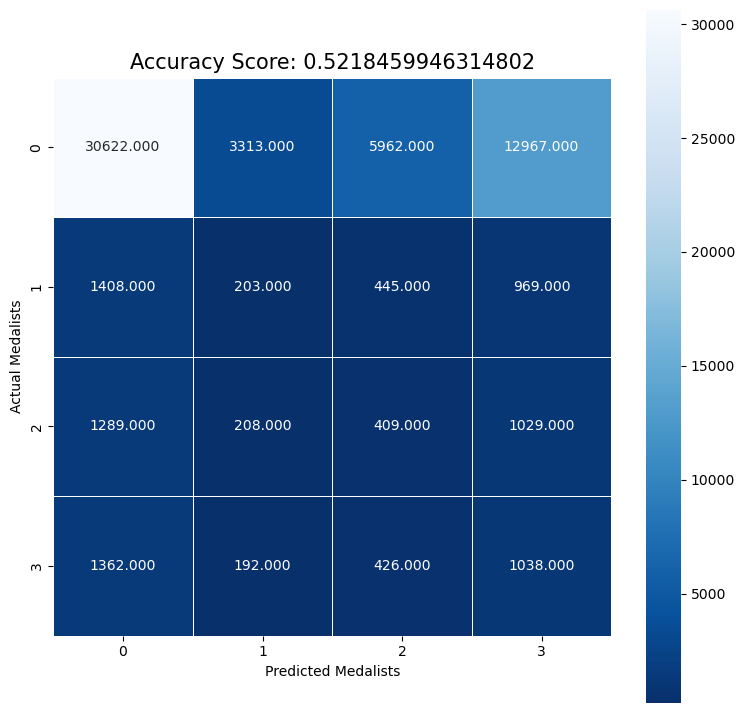

In [24]:
cm = metrics.confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Medalists');
plt.xlabel('Predicted Medalists');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);